# Filter + Calibration - Armonk - V1

In [20]:
from my_functions_v1 import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
from csv import writer
import sympy as sym 
import math
from functools import partial
from collections import Counter
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal, CompleteMeasFitter, TensoredMeasFitter)

from classification import *

from qiskit import *
from qiskit import IBMQ 
from qiskit import pulse
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit import schedule
from qiskit import execute



# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
#### from qiskit.visualization import * # Aparentemente tem que comentar essa linha aqui
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.jupyter import *
from qiskit.tools.visualization import plot_histogram

#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.pulse.library import Gaussian
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter, ParameterExpression  # This is Parameter Class for variable parameters.

from IPython.display import display, Math, Latex
import scipy.special  # https://stackoverflow.com/questions/36014733/official-abbreviation-for-import-scipy-as-sp-sc





us = 1.0e-6 
ns = 1.0e-9 
GHz = 1.0e9 
MHz = 1.0e6 
scale_factor = 1e-14


# load account credentials
IBMQ.load_account() 

ibmqfactory.load_account:WARNING:2021-09-09 16:05:25,067: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [59]:
hub = 'ibm-q-research'
group = 'jerusalem-1'
project = 'main'

# hub='ibm-q'
# group='open'
# project='main'

backend_name =  'ibmq_armonk'  

provider = IBMQ.get_provider(hub=hub, group=group, project=project)

backend = provider.get_backend(backend_name)

backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend_props = backend.properties()

dt = backend_config.dt



assert backend_config.open_pulse , "Backend doesn't support Pulse!!!"
# print(backend_config.basis_gates)
# print(backend_config.hamiltonian['description'])  # Information about the Hamiltonian

display(Math(r'T_1(q_0)={} \ \mu\text{{s}}'.format(backend_props.t1(0)/us)))
display(Math(r'T_2(q_0)={} \ \mu\text{{s}}'.format(backend_props.t2(0)/us)))
display(Math(backend_config.hamiltonian['h_latex']))
display(Math(r'\omega_0={} \ \text{{GHz}}'.format(backend_config.hamiltonian["vars"]["wq0"]/GHz)))
display(Math(r'\Omega_0={} \ \text{{GHz}}'.format(backend_config.hamiltonian["vars"]["omegad0"]/GHz)))
display(Math(r'\Delta_0={} \ \text{{GHz}}'.format(backend_config.hamiltonian["vars"]["delta0"]/GHz)))
dt = backend_config.dt


print(f"Sampling time: {dt*1e9} ns")   
time.ctime() 

{'delta0': -2181477525.8495026, 'omegad0': 104517533.08603992, 'wq0': 31237509417.373302}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Sampling time: 0.2222222222222222 ns


'Thu Sep  9 16:42:52 2021'

# Small Action

In [114]:
ramsey_frequency = np.genfromtxt('ramsey_frequency.csv', delimiter=',')   
mean_exc = np.genfromtxt('mean_exc.csv', dtype=complex, delimiter=',')   
mean_gnd = np.genfromtxt('mean_gnd.csv', dtype=complex, delimiter=',')   

Here sigma_0 = 160dt or 0.035555555555555556us, duration = 0.28444444444444444us


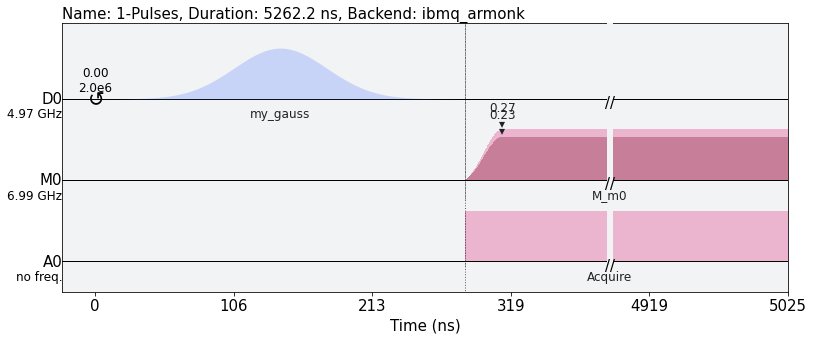

In [27]:
d0 = pulse.DriveChannel(0)
m0 = pulse.MeasureChannel(0)
a0 = pulse.AcquireChannel(0)
mem_slot = 0
qubit = 0


def my_gauss(amp, sigma, duration):
    return pulse.Gaussian(duration = duration,
                          amp =  amp, 
                          sigma = sigma, 
                          name = 'my_gauss')


def my_drag(amp, sigma, duration, beta):
    return pulse.Drag(duration = duration, 
                        amp = amp, 
                        sigma = sigma, 
                        beta = beta, 
                        name = 'my_drag')


# pi pulse - calibration
amp_0 = 0.01 # 0.1408940367454696 
sigma_0 = 160 #336 #500
dur_fact = 8
beta = -1.2293053750989376 


print(f'Here sigma_0 = {sigma_0}dt or {sigma_0 * dt/us}us, duration = {dur_fact * sigma_0* dt/us}us')


def My_scheds(n, fac):
    Sig_x = sigma_0 * fac 
    Amp_x = amp_0 / fac            
    Dur_x = dur_fact * Sig_x   
    return my_scheds[n].assign_parameters({sig_x: Sig_x, amp_x: Amp_x, dur_x:  Dur_x}, inplace=False)  


my_scheds = []
sig_x, amp_x, dur_x = Parameter('sig_x'), Parameter('amp_x'), Parameter('dur_x') 
for n in range(0,10): 
    with pulse.build(backend, name=f"{n}-Pulses") as my_sched:
        pulse.set_frequency(ramsey_frequency, d0)
        for loop_counts in range(0,n):
            sigma = sig_x
            amp = amp_x 
            duration = dur_x
            pulse.play(my_gauss(amp, sigma, duration), d0)       # GAUSS
#             pulse.play(my_drag(amp, sigma, duration, beta), d0)  # DRAG
        pulse.barrier(d0,m0)
        pulse.barrier(d0,a0)
        # Measurement! 
        pulse.measure(qubits = qubit, registers=[pulse.MemorySlot(mem_slot)])
    my_scheds.append(my_sched)  


# Exemple    
My_scheds(1,1).draw(style=IQXDebugging(), backend=backend, time_range=(0 , 5000 * ns/dt))  

In [81]:
fac_range = [1]  
                 
                            
def sched_batch_gauss(n, m):                           
    tab = []                                           
    for k in range(0, m):             # batches loop     
        for j in fac_range:           # factor  loop
            for i in range(0, n+1):   # pulses  loop
                tab.append(My_scheds(i, j))
    return tab  


pulse_num = 1                 
batches_num = 35
shots_num = 8192


job = backend.run(sched_batch_gauss(pulse_num,batches_num), 
                  meas_level = 1, 
                  meas_return = 'single', 
                  shots = shots_num)

print(job.job_id())
job_monitor(job)
time.ctime()  

613a67e388745f87dcb9c416
Job Status: job has successfully run


'Thu Sep  9 17:14:11 2021'

In [82]:
points_results = job.result(timeout=120)

In [83]:
def res_tot(i, j):       # pulse & factor
    l_1 = pulse_num+1    
    l_2 = len(fac_range)    
    l_3 = batches_num
    if i > l_1-1:
        y = error
    elif j > l_2-1:   
        y = error
    else:
        y = points_results.get_memory(i+j*l_1)                               
        for m in range( i + l_1*(j + l_2), l_1*l_2*l_3, l_1*l_2):
            y = np.append(y, points_results.get_memory(m))
    return y*scale_factor                                    # <---------- scale_factor --------------------

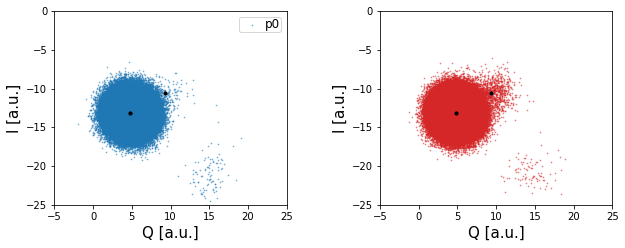

In [98]:
%matplotlib inline

fig = plt.figure()

fig.set_figheight(10)
fig.set_figwidth(10)

ax1 = fig.add_subplot(1,2,1, aspect=1)
ax2 = fig.add_subplot(1,2,2, aspect=1)
# ax3 = fig.add_subplot(1,3,3, aspect=1)

ax1.scatter(np.real(res_tot(0, 0)), np.imag(res_tot(0, 0)), 
            s=0.5, cmap='viridis', c='tab:blue', alpha=0.5, label='p0')

ax2.scatter(np.real(res_tot(1, 0)), np.imag(res_tot(1, 0)), 
            s=0.5, cmap='viriscale_factordis', c='tab:red', alpha=0.5, label='p1')


# ax3.scatter(np.real(res_tot(2, 0)), np.imag(res_tot(2, 0)), 
#             s=5, cmap='viridis', c='tab:blue', alpha=0.5, label='p2')


ax1.set_xlim([-5, 25])
ax1.set_ylim([-25, 0])

ax2.set_xlim([-5, 25])
ax2.set_ylim([-25, 0])

# ax3.set_xlim([-10, 20])
# ax3.set_ylim([-30, 0])




# mean point
ax1.scatter(np.real(mean_gnd), np.imag(mean_gnd), s=10, cmap='viridis', c='k', alpha=1.0)
ax1.scatter(np.real(mean_exc), np.imag(mean_exc), s=10, cmap='viridis', c='k', alpha=1.0)

ax2.scatter(np.real(mean_gnd), np.imag(mean_gnd), s=10, cmap='viridis', c='k',alpha=1.0)
ax2.scatter(np.real(mean_exc), np.imag(mean_exc), s=10, cmap='viridis', c='k',alpha=1.0)


ax1.set_ylabel('I [a.u.]', fontsize=15)
ax1.set_xlabel('Q [a.u.]', fontsize=15)
ax2.set_ylabel('I [a.u.]', fontsize=15)
ax2.set_xlabel('Q [a.u.]', fontsize=15)
# ax3.set_ylabel('I [a.u.]', fontsize=15)
# ax3.set_xlabel('Q [a.u.]', fontsize=15)

# ax1.set_title("$r=d/2$", fontsize=20)
# ax2.set_title("$r=d/4$", fontsize=20)
# ax3.set_title("$D=\lambda d$,   $\quad\lambda={}$".format(my_plot_factor), fontsize=20)


ax1.legend(fontsize=12, loc='upper right', borderpad=0.1, handletextpad=0.05)
# ax2.legend(fontsize=12, loc='upper right', borderpad=0.1, handletextpad=0.05)
# ax3.legend(fontsize=12, loc='upper right', borderpad=0.1, handletextpad=0.05)


plt.subplots_adjust(wspace=0.4)

#plt.savefig('comparing.png', dpi=400, bbox_inches = 'tight')





# Show graphic
plt.show();

In [122]:
mat_filt_from_rabi = np.genfromtxt('mat_filt.csv', delimiter=',')   
LAMBDA = np.genfromtxt('LAMBDA.csv', delimiter=',')   

display(mat_filt_from_rabi)
display(LAMBDA)

array([[ 1.00253281, -0.02106044],
       [-0.00253281,  1.02106044]])

array(1.3)

In [123]:

Filter_Cal = True


new_dic_counts = {}
for j in range(0, len(fac_range)):                 
    for i in range(0, pulse_num+1):                
        new_dic_counts[i, j] = classify_v3_map(res_tot(i, j), LAMBDA, mean_gnd, mean_exc)
        del new_dic_counts[i, j]["<class 'ValueError'>"]

        
def vec_fillter(i,j):
    vec = np.array([new_dic_counts[i,j]['0'], new_dic_counts[i,j]['1']])
    if Filter_Cal == True:
        vec_filter = np.dot(mat_filt_from_rabi,vec)
    elif Filter_Cal == False:     
        vec_filter = vec
    else:
        vec_filter = error    
    dic = {'0': round(vec_filter[0]), '1': round(vec_filter[1])}  
    return dic


def R_(i,j):
    return vec_fillter(i,j)['0']/(vec_fillter(i,j)['0']+vec_fillter(i,j)['1'])


def BINOMIAL(n, m):
    if n < 0 and m > 0:
        return (-1)**m * scipy.special.comb(-n+m-1, m) 
    if n < 0 and m < 0:
        if -m >= -n: 
            return (-1)**(-m+n) * scipy.special.comb(-m-1, -n-1)
        if -m < -n:
            return 0
    else:
        return scipy.special.comb(n, m)

def S_(n,j):
    ma = []
    for m in range(1, n+1):
        ma.append(BINOMIAL(m-n-1, m+n) * R_(m,j))
    return (1/2)**(2*n-1)  * BINOMIAL(2*n-1, n-1) * R_(0,j)  + ((-1)**n)/(2**(2*n-1)) * np.sum(ma)    


def diss_rate(n,j):
    if   n == 1:
        res = 2*S_(1,j)
    elif n == 2:    
        res = 4*S_(2,j)
    elif n == 3:
        res = 16/3*S_(3,j)
    elif n == 4:
        res = 16/3*S_(4,j)   
    elif n == 5:
        res = 32/5 * S_(5,j)
    else:
        res = error
    return res

In [124]:
print(f'\n{time.ctime()}\n\nTotal shots: {batches_num*shots_num}')  
print(f'Filter: {Filter_Cal}')  
print(f'Amp_0: {amp_0} \nsigma_0: {sigma_0}, dur_fact: {dur_fact}, fac_range: {fac_range}')
print(f"{backend_config.hamiltonian['vars']}, t1(0)={backend_props.t1(0)}, t2(0)={backend_props.t2(0)}\n")

for i in range(0,pulse_num+1):
    for j in range(0,len(fac_range)):
        print(f'R_({i},{j}) = {R_(i,j)}')              
print('\n')    
for i in range(0,pulse_num+1):
    for j in range(0,len(fac_range)):
        print(f'S_({i},{j}) = {S_(i,j)}')              
print("\n")        
for i in range(1,pulse_num+1):
    for j in range(0,len(fac_range)):
        print(f'diss_rate({i},{j}) = {diss_rate(i,j)}')                  
print("\n")   


Thu Sep  9 23:38:22 2021

Total shots: 286720
Filter: True
Amp_0: 0.01 
sigma_0: 160, dur_fact: 8, fac_range: [1]
{'delta0': -2181477525.8495026, 'omegad0': 104517533.08603992, 'wq0': 31237509417.373302}, t1(0)=0.00014397549069165272, t2(0)=0.0002507746989760038

R_(0,0) = 1.0001371585324037
R_(1,0) = 0.9966681219697143


S_(0,0) = 2.0002743170648074
S_(1,0) = 0.001734518281344688


diss_rate(1,0) = 0.003469036562689376




In [111]:
print(f'\n{time.ctime()}\n\nTotal shots: {batches_num*shots_num}')  
print(f'Filter: {Filter_Cal}')  
print(f'Amp_0: {amp_0} \nsigma_0: {sigma_0}, dur_fact: {dur_fact}, fac_range: {fac_range}')
print(f"{backend_config.hamiltonian['vars']}, t1(0)={backend_props.t1(0)}, t2(0)={backend_props.t2(0)}\n")

for i in range(0,pulse_num+1):
    for j in range(0,len(fac_range)):
        print(f'R_({i},{j}) = {R_(i,j)}')              
print('\n')    
for i in range(0,pulse_num+1):
    for j in range(0,len(fac_range)):
        print(f'S_({i},{j}) = {S_(i,j)}')              
print("\n")        
for i in range(1,pulse_num+1):
    for j in range(0,len(fac_range)):
        print(f'diss_rate({i},{j}) = {diss_rate(i,j)}')


Thu Sep  9 23:15:29 2021

Total shots: 286720
Filter: True
Amp_0: 0.01 
sigma_0: 160, dur_fact: 8, fac_range: [1]
{'delta0': -2181477525.8495026, 'omegad0': 104517533.08603992, 'wq0': 31237509417.373302}, t1(0)=0.00014397549069165272, t2(0)=0.0002507746989760038

R_(0,0) = 1.0005401208520406
R_(1,0) = 0.9981462444597988


S_(0,0) = 2.001080241704081
S_(1,0) = 0.001196938196120878


diss_rate(1,0) = 0.002393876392241756


In [ ]:
# timestr = time.strftime("%Y-%m-%d---%H-%M-%S")
# sys.stdout = open(f"data-{timestr}.txt", "w")
# print("-"*65, file=open(f"data-{timestr}.txt", "w"))

# print(f'\n{time.ctime()}\n\nTotal shots: {batches_num*shots_num}')  
# print(f'Filter = {Filter_Cal}')  
# print(f'Amp_0: {amp_0} \nsigma_0: {sigma_0}') 
# print(f'dur_fact: {dur_fact}')           
# print(f'fac_range: {fac_range}\n')
# for i in range(0,pulse_num+1):
#     for j in range(0,len(fac_range)):
#         print(f'R_({i},{j}) = {R_(i,j)}')              
# print('\n')    
# for i in range(0,pulse_num+1):
#     for j in range(0,len(fac_range)):
#         print(f'S_({i},{j}) = {S_(i,j)}')              
# print("\n")        
# for i in range(1,pulse_num+1):
#     for j in range(0,len(fac_range)):
#         print(f'diss_rate({i},{j}) = {diss_rate(i,j)}')                  
# print("\n")   
# sys.stdout.close()


In [75]:
print(f'\n{time.ctime()}\n\nTotal shots: {batches_num*shots_num}')  
print(f'Filter: {Filter_Cal}')  
print(f'Amp_0: {amp_0} \nsigma_0: {sigma_0}') 
print(f'dur_fact: {dur_fact}')           
print(f'fac_range: {fac_range}')
print(f"{backend_config.hamiltonian['vars']}, t1(0)={backend_props.t1(0)}, t2(0)={backend_props.t2(0)}\n")

for i in range(0,pulse_num+1):
    for j in range(0,len(fac_range)):
        print(f'R_({i},{j}) = {R_(i,j)}')              
print('\n')    
for i in range(0,pulse_num+1):
    for j in range(0,len(fac_range)):
        print(f'S_({i},{j}) = {S_(i,j)}')              
print("\n")        
for i in range(1,pulse_num+1):
    for j in range(0,len(fac_range)):
        print(f'diss_rate({i},{j}) = {diss_rate(i,j)}')                  
print("\n")    


Thu Sep  9 16:48:41 2021

Total shots: 98304
Filter: True
Amp_0: 0.01 
sigma_0: 160
dur_fact: 8
fac_range: [1, 2, 3]
{'delta0': -2181477525.8495026, 'omegad0': 104517533.08603992, 'wq0': 31237509417.373302}, t1(0)=0.00014397549069165272, t2(0)=0.0002507746989760038

R_(0,0) = 0.9999506465304511
R_(0,1) = 0.999653987790712
R_(0,2) = 0.9996173784250802
R_(1,0) = 0.9975068499913604
R_(1,1) = 0.9976824457593688
R_(1,2) = 0.998778169970133


S_(0,0) = 1.9999012930609021
S_(0,1) = 1.999307975581424
S_(0,2) = 1.9992347568501605
S_(1,0) = 0.0012218982695453295
S_(1,1) = 0.0009857710156715993
S_(1,2) = 0.00041960422747361337


diss_rate(1,0) = 0.002443796539090659
diss_rate(1,1) = 0.0019715420313431986
diss_rate(1,2) = 0.0008392084549472267




In [ ]:
    if collect_data:
        print("-"*65, file=open("data_class_3.txt", "a"))
        print(f'\n{time.ctime()}\n\nTotal shots: {batches_num*shots_num}', file=open("data_class_3.txt", "a"))  
        print(f'Amp_0: {amp_0} \nsigma_0: {sigma_0}', file=open("data_class_3.txt", "a")) 
        print(f'dur_fact: {dur_fact}', file=open("data_class_3.txt", "a"))           
        print(f'fac_range: {fac_range}\n', file=open("data_class_3.txt", "a"))
        for i in range(0,pulse_num+1):
            for j in range(0,len(fac_range)):
                print(f'R_({i},{j}) = {R_(i,j)}', file=open("data_class_3.txt", "a"))              
        print('\n')    
        for i in range(0,pulse_num+1):
            for j in range(0,len(fac_range)):
                print(f'S_({i},{j}) = {S_(i,j)}', file=open("data_class_3.txt", "a"))              
        print("\n")        
        for i in range(1,pulse_num+1):
            for j in range(0,len(fac_range)):
                print(f'diss_rate({i},{j}) = {diss_rate(i,j)}', file=open("data_class_3.txt", "a"))                  
        print("\n")    
        


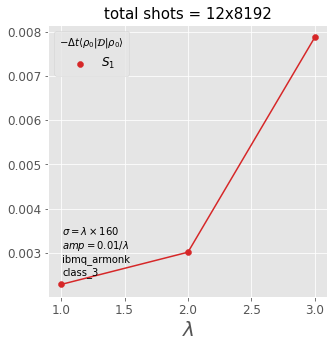

In [162]:
%matplotlib inline



fig = plt.figure()

plt.style.use('ggplot')
#plt.style.use('default')
   
X = fac_range
    
ax = fig.add_subplot(1,1,1)

fig.set_figheight(5)
fig.set_figwidth(5)

plt.tick_params(labelsize=12)

#plt.xlabel("Drive amp [a.u.]")
#plt.ylabel("Measured signal [a.u.]")
Y1 = [diss_rate(1,i) for i in range(0,len(fac_range))]
ax.scatter(X, Y1, color='tab:red', label='$S_1$')
ax.plot(X, Y1, color='tab:red') 

# Y2 = [diss_rate(2,i)for i in range(0,len(fac_range))]
# ax.scatter(X, Y2, color='tab:blue', label='$S_2$')
# ax.plot(X, Y2, color='tab:blue') 

# Y3 = [diss_rate(3,i) for i in range(0,len(fac_range))]
# ax.scatter(X, Y3, color='tab:green', label='$S_3$')
# ax.plot(X, Y3, color='tab:green') 

# Y4 = [diss_rate(4,i) for i in range(0,len(fac_range))]
# plt.scatter(X, Y4, color='tab:orange', label='$S_4$')
# plt.plot(X, Y4, color='tab:orange') 


ax.text(0.05, 0.07, '$\\sigma=\\lambda\\times{0}$\n$amp={1}/\\lambda$\n{2}\nclass_3'.format(sigma_0,amp_0,backend_name),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='black', fontsize=10)


ax.set_xlabel('$\lambda$', fontsize=20)
ax.legend(title='$-\\Delta t \\langle\\rho_0|\\mathcal{D}|\\rho_0\\rangle $',fontsize=12)
ax.set_title("total shots = {0}x{1}".format(batches_num,shots_num), fontsize=15)

# if class_3:
#     timestr = time.strftime("%Y-%m-%d---%H-%M-%S")
#     plt.savefig(f'class_3-{timestr}.png', dpi=400, bbox_inches = 'tight')


plt.show()

In [60]:
backend_config.hamiltonian['vars']

{'delta0': -2181477525.8495026,
 'omegad0': 104517533.08603992,
 'wq0': 31237509417.373302}